<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks. Given a query image, we find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the images with the lowest distance to the query image.

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="600px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images independently as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to be unit vectors, i.e. have an L2 norm of one.
- Finally, obtaining the distance between the two input images by computing the L2 distance between their respective DNN representations.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed. This is followed by a quantitative evaluation of the proposed image similarity system.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
from fastai.vision import (
    accuracy,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
    partial,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. To train your own image retrieval systems, simply change the `DATA_PATH` variable below to point to a different (single-label) dataset.

In [4]:
# Set dataset, model and evaluation parameters
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/test"
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cars196/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cars196/test"
#DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset20/train"
#DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset20/test"
DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/train"
DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/test"

# DNN configuration and learning parameters
EPOCHS_HEAD = 8
EPOCHS_BODY = 0 #12
LEARNING_RATE = 10* 1e-4
BATCH_SIZE = 16
ARCHITECTURE = models.resnet18
IM_SIZE = 224 #300

In [5]:
models.resnet18

<function torchvision.models.resnet.resnet18(pretrained=False, progress=True, **kwargs)>

In [6]:
# import torch.nn as nn
# class MyModel(models.resnet18):
#     def __init__(self): 
#         pass
#         #super(models.resnet18, self).__init__()


We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

In [7]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data_finetune = (
    ImageList.from_folder(DATA_FINETUNE_PATH)
    .split_by_rand_pct(valid_pct=0.1, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"""\FINE-TUNING:
Training set: {len(data_finetune.train_ds.x)} images
Validation set: {len(data_finetune.valid_ds.x)} images\
"""
)

# Display example images
#data_finetune.show_batch(rows=3, figsize=(6, 6))

\FINE-TUNING:
Training set: 5278 images
Validation set: 586 images


## Classification model fine-tuning

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [8]:
learn = cnn_learner(
    data_finetune,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
)

### TEST - ADD NORMALIZATION LAYER TO LEARNER

In [9]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=100, bias=True)
)

In [10]:
# import math
# import torch
# import torch.nn as nn
# from torch.nn import Parameter

# class NormSoftmaxLoss(nn.Module):
#     """
#     L2 normalize weights and apply temperature scaling on logits.
#     https://github.com/azgo14/classification_metric_learning/blob/master/metric_learning/modules/losses.py#L7
#     """
#
#     def __init__(self, dim, num_instances, temperature=0.05):
#         super(NormSoftmaxLoss, self).__init__()
#         self.weight = Parameter(torch.Tensor(num_instances, dim))
#         # Initialization from nn.Linear (https://github.com/pytorch/pytorch/blob/v1.0.0/torch/nn/modules/linear.py#L129)
#         stdv = 1. / math.sqrt(self.weight.size(1))
#         self.weight.data.uniform_(-stdv, stdv)
#         self.temperature = temperature
#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(self, embeddings, instance_targets):
#         norm_weight = nn.functional.normalize(self.weight, dim=1)
#         prediction_logits = nn.functional.linear(embeddings, norm_weight)
#         loss = self.loss_fn(prediction_logits / self.temperature, instance_targets)
#         return loss

import torch
from IPython.core.debugger import set_trace

class MyL2Norm(torch.nn.Module):
    def __init__(self):
        super(MyL2Norm, self).__init__()

    def forward(self, input):
        return torch.nn.functional.normalize(input, dim=1)

In [ ]:
if False:
    modules = []
    modules.append(learn.model[1][0])
    modules.append(learn.model[1][1])
    modules.append(learn.model[1][2])
    modules.append(learn.model[1][3])
    modules.append(learn.model[1][4])
    modules.append(learn.model[1][5])
    modules.append(MyL2Norm())
    modules.append(learn.model[1][6])
    learn.model[1] = torch.nn.Sequential(*modules)
    learn.model[1]

In [12]:
learn.model.forward

<bound method Sequential.forward of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

### Run DNN training

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,3.343218,2.926512,0.356003,0.505119,02:36
1,1.722793,1.673745,0.533815,0.551195,01:41
2,1.310524,1.409005,0.636398,0.600683,01:40
3,1.037447,1.116709,0.718655,0.694539,01:42
4,0.748556,0.957817,0.780775,0.723549,01:46
5,0.571592,0.816955,0.845365,0.771331,01:37
6,0.377867,0.748189,0.908625,0.784983,01:43
7,0.296532,0.737368,0.935600,0.791809,01:39


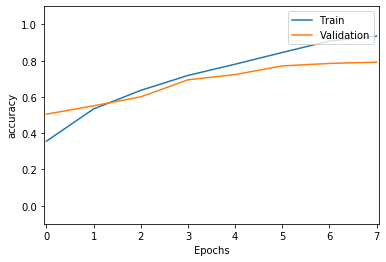

In [17]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, 10* LEARNING_RATE) #, callbacks = [MyCallback()])

Let's now unfreeze all the layers and fine-tuning the model more 

In [18]:
learn.unfreeze()
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time


C:\Anaconda\envs\cv\lib\site-packages\fastprogress\fastprogress.py:102: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


## Feature extraction

Before computing the feature representation for each image, let's look at its architecture and in particular the last layers. Fast.ai's ResNet-18 model is composed of a different set of final layers (here: `(1): Sequential`). As discussed at the start of this notebook, we use the output of the penultimate layer (here: `(6): BatchNorm1d`) as our image representation.

\FINE-TUNING:
Training set: 5924 images
Validation set: 1 images


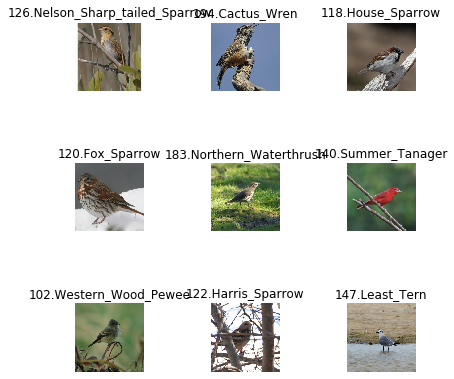

In [19]:
# Load images into fast.ai's ImageDataBunch object
data_rank = (
    ImageList.from_folder(DATA_RANKING_PATH)
    .split_none()
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"""\FINE-TUNING:
Training set: {len(data_rank.train_ds.x)} images
Validation set: {len(data_rank.valid_ds.x)} images\
"""
)

# Display example images
data_rank.show_batch(rows=3, figsize=(6, 6))

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The following line will allow us to extract the penultimate layer (ie 512 floating points vector) after running an image  through the model.

In [21]:
# Use penultimate layer as image representation
embedding_layer = learn.model[1][-2] 
print(embedding_layer)

MyL2Norm()


In [22]:
#Compute DNN features for all validation images
dnn_features = compute_features_learner(data_rank, DatasetType.Train, learn, embedding_layer)

## Image Retrieval Example
The cell below shows how to find and display the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook. 

We use the L2 distance which is defined as <sup> $ \sqrt{\sum_{i=1}^{n}{(F_{q}[i] - F_{r}[i])^{2}}} $ </sup> where $F_{q}$ and $F_{r}$ are the features of a query image and a reference image respectively, and $n=512$ is their dimensionality. By default, we normalize the feature vectors $F_{q}$ and $F_{r}$ to be unit-length, i.e. have a magnitude ||$F$|| of 1, before computing the L2 distance. One could also use other distances measures, such as L1 or cosine similarity, however L2 with unit-length normalized feature vectors seems to work well in practice. 

Query image path: C:\Users\pabuehle\Desktop\data\cub_200_2011\test\101.White_Pelican\White_Pelican_0005_95916.jpg
Query feature dimension: 512


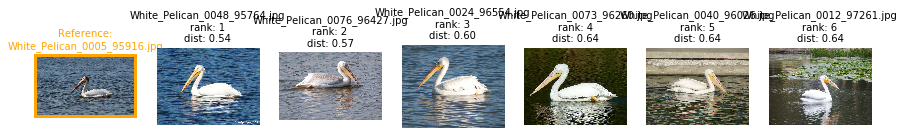

In [23]:
# Get the DNN feature for the query image
query_im_path =  str(data_rank.train_ds.items[1])
query_feature = dnn_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == 512

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, dnn_features)
plot_distances(distances, num_rows=1, num_cols=7, figsize=(15,5))

## Quantitative evaluation

Our aim in the section below is to reproduce Recall@K results reported in SOTA publications for the (i) CUB-200-2011 dataset and (ii) CARS 196 datasets. 

The general approach is as follows:
- We extract the features of each query image in the query set, and search the K most similar images in the gallery set. 
- If one of the K retrieved images have the same label with the query image, then that increases recall.


### Dataset-specific setups:

We follow the literature closely when setting up our experiments. See https://arxiv.org/abs/1511.06452:

- CUB200-2011 dataset: 
   - all images in `data_rank` are used as both the query set and the gallery set. 
   - The images within the first 100 of the 200 classes from the dataset are used for training the DNN, the remaining 100 classes are used to compute Recall@K.

- CARS196: 
   - The images within the first 98 of the 196 classes from the dataset are used for training the DNN, the remaining 98 classes are used to compute Recall@K.


In [ ]:
#init
rank1_count = 0
labels = data_rank.train_ds.y
#im_paths = [str(s) for s in list(data_rank.train_ds.items)]
im_paths = data_rank.train_ds.items
assert len(labels) == len(im_paths) == len(dnn_features)

query_indices = range(len(im_paths))[::11] #only use every nth image to speed up accuracy computation

# Loop over all images and use as query image once
for query_index in query_indices:
    if query_index % 1000 == 0:
        print(query_index, len(im_paths))

    # Get query information
    query_im_path =  str(im_paths[query_index])
    query_feature = dnn_features[query_im_path]
    
    # Compute distance to all images in the gallery set
    distances = compute_distances(query_feature, dnn_features)

    # Find the smallest distance
    minDist = float('inf')
    minDistIndex = None
    for index, distance in enumerate(distances):
        if index == query_index: #ignore the query image itself
            continue

        if distance[1] < minDist:
            minDist = distance[1]
            minDistIndex = index

    # Compute rank
    if labels[query_index] == labels[minDistIndex]:
        rank1_count += 1
        
print(rank1_count, len(query_indices))

0 5924


In [ ]:
print("Recall@1 accuracy = {:2.2f}".format(100.0 * rank1_count / len(query_indices)))

In [ ]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
#sb.glue("median_rank", median_rank)
#sb.glue("random_rank", random_rank)

# Appendix
### Example how to use callbacks

In [ ]:
# from fastai.callback import Callback
# from IPython.core.debugger import set_trace          
              
# class MyCallback():
#     "Base class for callbacks that want to record values, dynamically change learner params, etc."
#     _order=0
#     def on_train_begin(self, **kwargs)->None:
#         "To initialize constants in the callback."
#         pass
#     def on_epoch_begin(self, **kwargs)->None:  
#         "At the beginning of each epoch."
#         pass
    
    
#     def on_batch_begin(self, **kwargs)->None:
#         "Set HP before the output and loss are computed."
#         pass
    
    
#     def on_loss_begin(self, last_output, **kwargs)->None:
#         "Called after forward pass but before loss has been computed."
#         #last_input == RGB image normalized
#         #x = nn.functional.normalize(x, dim=1)
#         #print(kwargs)
#         #print(last_output)
#         #set_trace()
#         #last_output = 100*last_output
#         pass
              
#     def on_backward_begin(self, **kwargs)->None:
#         "Called after the forward pass and the loss has been computed, but before backprop."
#         pass
#     def on_backward_end(self, **kwargs)->None:
#         "Called after backprop but before optimizer step. Useful for true weight decay in AdamW."
#         pass
#     def on_step_end(self, **kwargs)->None:
#         "Called after the step of the optimizer but before the gradients are zeroed."
#         pass
#     def on_batch_end(self, **kwargs)->None:
#         "Called at the end of the batch."
#         pass
#     def on_epoch_end(self, **kwargs)->None:
#         "Called at the end of an epoch."
#         pass
#     def on_train_end(self, **kwargs)->None:
#         "Useful for cleaning up things and saving files/models."
#         pass